## HW4: Deep Learning
### Anagh Mishra

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, auc
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

import time
import datetime
torch.manual_seed(42)

print(torch.__version__)
print(torch.version.cuda)

2.9.0+cu128
12.8


/home/anagh/Repos/RadioFINN/vanilla_env/.pixi/envs/default/lib/python3.12/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: /home/anagh/Repos/RadioFINN/vanilla_env/.pixi/envs/default/lib/python3.12/site-packages/torch_scatter/_version_cpu.so
  import torch_geometric.typing
/home/anagh/Repos/RadioFINN/vanilla_env/.pixi/envs/default/lib/python3.12/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: Could not load this library: /home/anagh/Repos/RadioFINN/vanilla_env/.pixi/envs/default/lib/python3.12/site-packages/torch_cluster/_version_cpu.so
  import torch_geometric.typing
/home/anagh/Repos/RadioFINN/vanilla_env/.pixi/envs/default/lib/python3.12/site-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. St

In [3]:
! pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cpu.html

! pip install torch_geometric

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cpu.html


In [4]:

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

dataset = TUDataset(root='data/ENZYMES', name='ENZYMES', use_node_attr=True)
num_graphs = len(dataset)
num_classes = dataset.num_classes
num_node_features = dataset.num_features

print(f"Total number of graphs: {num_graphs}")
print(f"Number of classes: {num_classes}")
print(f"Number of node features: {num_node_features}\n")


has_nan = False
for data in dataset:
    if data.x is not None:
        if torch.isnan(data.x).any():
            has_nan = True
            break

print(f"Are there any NaN or missing node features?: {has_nan}")
print()

Total number of graphs: 600
Number of classes: 6
Number of node features: 21

Are there any NaN or missing node features?: False



In [5]:
dataset = dataset.shuffle()

num_graphs = len(dataset)
train_end = int(0.8 * num_graphs)
val_end   = int(0.9 * num_graphs)

train_dataset = dataset[:train_end]
val_dataset   = dataset[train_end:val_end]
test_dataset  = dataset[val_end:]

x_train = torch.cat([data.x for data in train_dataset], dim=0)
mean = x_train.mean(dim=0)
std = x_train.std(dim=0)
std[std == 0] = 1.0  # avoid division by zero


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

## GCN 1 Layer Model with No Dropouts, essentially our extreme baseline

In [6]:
class GCN1_NDP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)  # Graph-level embedding
        return self.fc(x)

## GCN 1 Layer Model with Dropouts

In [7]:
class GCN1(torch.nn.Module):
    def __init__(self, num_features, num_classes, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(num_features, 64)
        self.dropout = dropout
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = global_mean_pool(x, batch)
        return self.fc(x)

## GCN 2 Layer Model with No Dropouts

In [8]:
class GCN2_NDP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.fc(x)

## GCN 2 Layer Model with Dropouts

In [9]:
class GCN2(torch.nn.Module):
    def __init__(self, num_features, num_classes, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(num_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.dropout = dropout
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = global_mean_pool(x, batch)
        return self.fc(x)

In [10]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for data in loader:                      # data has x, edge_index, batch, y
        data = data.to(device)              
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

In [11]:
def test(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)

        correct += (pred == data.y).sum().item()
        total += data.y.size(0)

    return correct / total

In [12]:
def test_metrics(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        preds = out.argmax(dim=1).cpu().numpy()
        labels = data.y.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return acc, f1

In [13]:
def compute_auc(model, loader, device):
    model.eval()
    y_true = []
    y_score = []

    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        prob = F.softmax(out, dim=1)

        # store tensors; we'll detach later in one shot
        y_score.append(prob)
        y_true.append(data.y)

    # Concatenate, then detach + move to CPU + numpy
    y_score = torch.cat(y_score).detach().cpu().numpy()  # shape: [N, num_classes]
    y_true = torch.cat(y_true).detach().cpu().numpy()    # shape: [N]

    auc_val = roc_auc_score(y_true, y_score, multi_class='ovr')
    return auc_val, y_true, y_score

### Traing Models

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001
num_epochs = 300
criterion = torch.nn.CrossEntropyLoss()
# 1-GCN
gcn1_model = GCN1(num_features=num_node_features, num_classes=num_classes).to(device)
gcn1_optimizer = torch.optim.Adam(gcn1_model.parameters(), lr=lr)

gcn1_ndp_model = GCN1_NDP(num_features=num_node_features, num_classes=num_classes).to(device)
gcn1_ndp_optimizer = torch.optim.Adam(gcn1_ndp_model.parameters(), lr=lr)

# 2-GCN
gcn2_model = GCN2(num_features=num_node_features, num_classes=num_classes).to(device)
gcn2_optimizer = torch.optim.Adam(gcn2_model.parameters(), lr=lr)

gcn2_ndp_model = GCN2_NDP(num_features=num_node_features, num_classes=num_classes).to(device)
gcn2_ndp_optimizer = torch.optim.Adam(gcn2_ndp_model.parameters(), lr=lr)

In [15]:
start_time = datetime.datetime.now()
print(f"Training: {start_time}")
for epoch in range(1, num_epochs + 1):
    gcn1_train_loss = train(gcn1_model, train_loader, gcn1_optimizer, criterion, device)
    gcn1_val_acc    = test(gcn1_model, val_loader, device)

    gcn1_ndp_train_loss = train(gcn1_ndp_model, train_loader, gcn1_ndp_optimizer, criterion, device)
    gcn1_ndp_val_acc    = test(gcn1_ndp_model, val_loader, device)

    gcn2_train_loss = train(gcn2_model, train_loader, gcn2_optimizer, criterion, device)
    gcn2_val_acc    = test(gcn2_model, val_loader, device)

    gcn2_ndp_train_loss = train(gcn2_ndp_model, train_loader, gcn2_ndp_optimizer, criterion, device)
    gcn2_ndp_val_acc    = test(gcn2_ndp_model, val_loader, device)

    if(epoch%10 == 0):
        print(f"Epoch {epoch:03d} | "
            f"GCN1 loss: {gcn1_train_loss:.4f}, val acc: {gcn1_val_acc:.4f} || "
            f"GCN2 loss: {gcn2_train_loss:.4f}, val acc: {gcn2_val_acc:.4f} ||"
          f"GCN1 (NDP) loss: {gcn1_ndp_train_loss:.4f}, val acc: {gcn1_ndp_val_acc:.4f} || "
          f"GCN2 (NDP) loss: {gcn2_ndp_train_loss:.4f}, val acc: {gcn2_ndp_val_acc:.4f}")

Training: 2025-11-27 22:31:43.222495
Epoch 010 | GCN1 loss: 1.8078, val acc: 0.3000 || GCN2 loss: 1.8059, val acc: 0.2667 ||GCN1 (NDP) loss: 1.7137, val acc: 0.2833 || GCN2 (NDP) loss: 1.6750, val acc: 0.2833
Epoch 020 | GCN1 loss: 1.7156, val acc: 0.3000 || GCN2 loss: 1.7410, val acc: 0.2667 ||GCN1 (NDP) loss: 1.6904, val acc: 0.2000 || GCN2 (NDP) loss: 1.6319, val acc: 0.2833
Epoch 030 | GCN1 loss: 1.6512, val acc: 0.2833 || GCN2 loss: 1.6740, val acc: 0.2667 ||GCN1 (NDP) loss: 1.6615, val acc: 0.2500 || GCN2 (NDP) loss: 1.6111, val acc: 0.2667
Epoch 040 | GCN1 loss: 1.6239, val acc: 0.2667 || GCN2 loss: 1.6853, val acc: 0.2667 ||GCN1 (NDP) loss: 1.6283, val acc: 0.3500 || GCN2 (NDP) loss: 1.5679, val acc: 0.3500
Epoch 050 | GCN1 loss: 1.5848, val acc: 0.3500 || GCN2 loss: 1.6614, val acc: 0.2667 ||GCN1 (NDP) loss: 1.6292, val acc: 0.2833 || GCN2 (NDP) loss: 1.5387, val acc: 0.4167
Epoch 060 | GCN1 loss: 1.5837, val acc: 0.3500 || GCN2 loss: 1.6417, val acc: 0.3000 ||GCN1 (NDP) loss:

In [16]:
def test_metrics(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        preds = out.argmax(dim=1).cpu().numpy()
        labels = data.y.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    return acc, f1

In [17]:

def plot_multiclass_roc(y_true, y_score, num_classes, title):
    plt.figure(figsize=(8, 6))

    for i in range(num_classes):
        # One-vs-rest true labels
        y_true_bin = (y_true == i).astype(int)

        fpr, tpr, _ = roc_curve(y_true_bin, y_score[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f"Class {i} (AUC={roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

### Testing/Evaluating Models

Training: 2025-11-27 22:32:11.496377
Best Model GCN1 with val acc = 0.5500
GCN1: Accuracy=0.5500, F1=0.5173


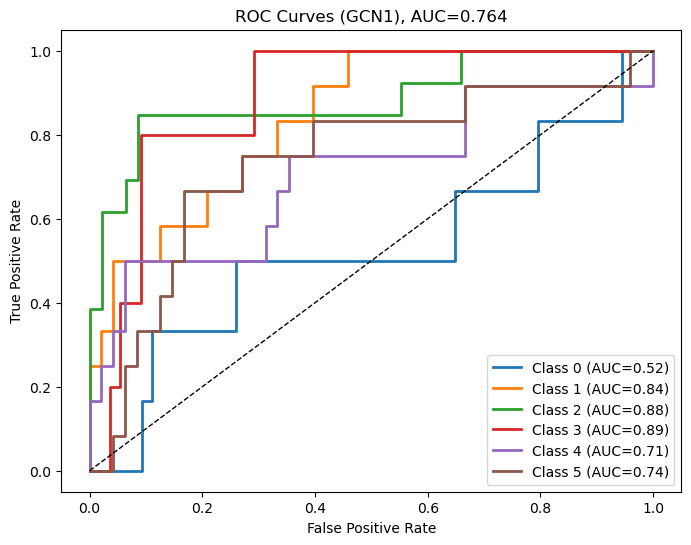

Training: 2025-11-27 22:32:11.575447
GCN1_NDP: Accuracy=0.4333, F1=0.3670


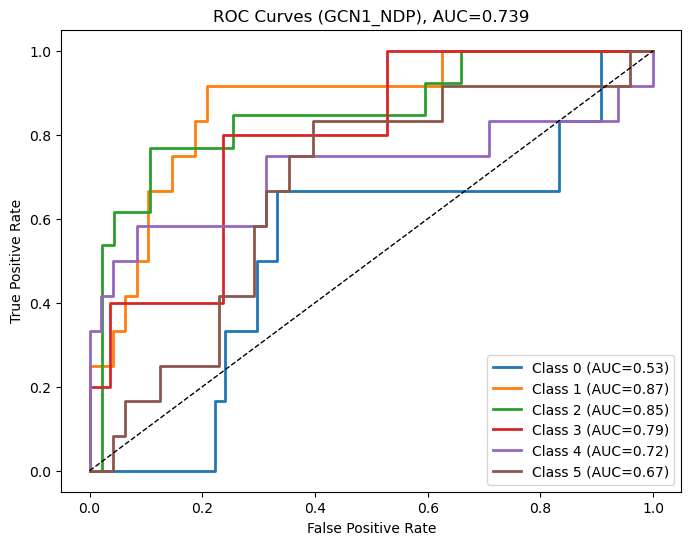

Training: 2025-11-27 22:32:11.633469
GCN2: Accuracy=0.5333, F1=0.4910


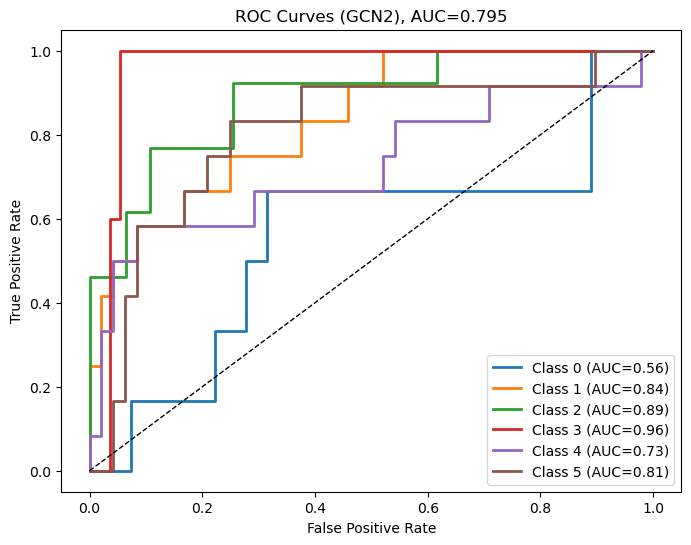

Training: 2025-11-27 22:32:11.691153
Best Model GCN2_NDP with val acc = 0.5667
GCN2_NDP: Accuracy=0.5667, F1=0.5427


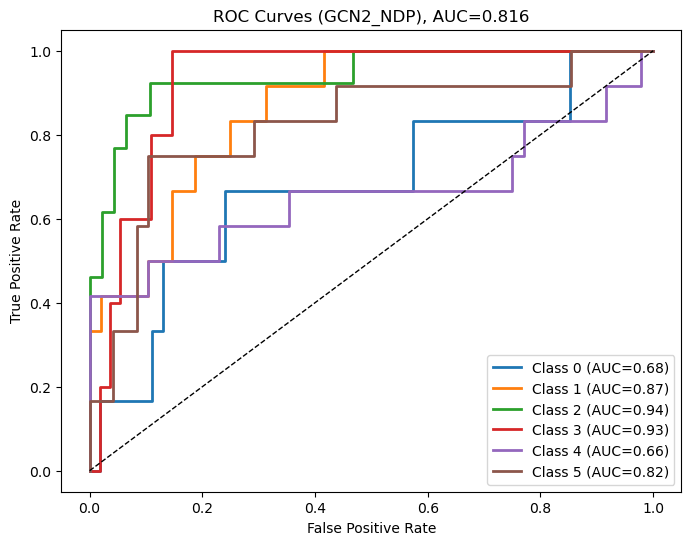

In [18]:
results = {}

models = {
    "GCN1": gcn1_model,
    "GCN1_NDP": gcn1_ndp_model,
    "GCN2": gcn2_model,
    "GCN2_NDP": gcn2_ndp_model
}
best_val = 0.0
best_path = "best_model.pth"
for name, model in models.items():
    start_time = datetime.datetime.now()
    print(f"Training: {start_time}")
    acc, f1 = test_metrics(model, test_loader, device=device)
    if acc > best_val:
        best_val = acc
        torch.save(model.state_dict(), best_path)
        print(f"Best Model {name} with val acc = {best_val:.4f}")
    results[name] = (acc, f1)
    print(f"{name}: Accuracy={acc:.4f}, F1={f1:.4f}")
    auc_val, y_true, y_score = compute_auc(model, test_loader, device)
    plot_multiclass_roc(y_true, y_score, num_classes=num_classes, title=f"ROC Curves ({name}), AUC={auc_val:.3f}")